# How to generate histograms using Oracle SQL

This provides and example of how to generate frequency histograms using the Oracle SQL.
Disambiguation: we refer here to computing histograms of table data, rather than histograms of the columns statistics used by the cost based optimizer.

Dependencies: needs an [Oracle client installation](http://www.oracle.com/technetwork/topics/linuxx86-64soft-092277.html) and [cx_Oracle](https://pypi.python.org/pypi/cx_Oracle)

Author and contacts: Luca.Canali@cern.ch

## Setup and prerequisites

## Query Oracle from Python with cx_Oracle

In [1]:
# connect to Oracle using cx_Oracle
# !pip install cx_Oracle if needed

import cx_Oracle

db_user = 'system'
db_connect_string = 'localhost:1521/XEPDB1'
db_pass = 'oracle'

# db_connect_string = 'dbserver:1521/orcl.mydomain.com'
# import getpass
# db_pass = getpass.getpass()


## Create the test table

In [2]:
with cx_Oracle.connect(user=db_user, password=db_pass, dsn=db_connect_string) as ora_conn:

    cursor = ora_conn.cursor()
    
    # use this drop statement if you need to recreate the table
    # cursor.execute("drop table data")

    cursor.execute("begin dbms_random.seed(4242); end;")

    cursor.execute("""
        create table data as 
        select dbms_random.value * 100 random_value 
        from dual connect by level <=100
        """)



## Define the query to compute the histogram

In [3]:
table_name = "data" # table or temporary view containing the data
value_col = "random_value" # column name on which to compute the histogram
min = -20  # min: minimum value in the histogram
max = 90   # maximum value in the histogram
bins = 11  # number of histogram buckets to compute
step = (max - min) / bins
        

query = f"""
with bucketized as (
  select width_bucket({value_col}, {min}, {max}, {bins}) as bucket
  from {table_name}
),
hist as (
  select bucket, count(*) as cnt
  from bucketized
  group by bucket
),
buckets as (
  select rownum as bucket from dual connect by level <= {bins}
)
select
    bucket, {min} + (bucket - 1/2) * {step} as value,
    nvl(cnt, 0) as count
from hist right outer join buckets using(bucket)
order by bucket
"""

## Fetch the histogram data into a pandas dataframe

In [4]:
import pandas as pd

# query Oracle using ora_conn and put the result into a pandas Dataframe
with cx_Oracle.connect(user=db_user, password=db_pass, dsn=db_connect_string) as ora_conn:
    hist_pandasDF = pd.read_sql(query, con=ora_conn)    

# Decription
#
# BUCKET: the bucket number, range from 1 to bins (included)
# VALUE: midpoint value of the given bucket
# COUNT: number of values in the bucket 
            
hist_pandasDF

,BUCKET,VALUE,COUNT
0,1,-15,0
1,2,-5,0
2,3,5,9
3,4,15,7
4,5,25,12
5,6,35,13
6,7,45,7
7,8,55,11
8,9,65,8
9,10,75,13


In [5]:
# Optionally normalize the event count into a frequency
# dividing by the total number of events
 
hist_pandasDF["FREQUENCY"] = hist_pandasDF["COUNT"] / sum(hist_pandasDF["COUNT"]) 
              
hist_pandasDF

,BUCKET,VALUE,COUNT,FREQUENCY
0,1,-15,0,0.000000
1,2,-5,0,0.000000
2,3,5,9,0.098901
3,4,15,7,0.076923
4,5,25,12,0.131868
5,6,35,13,0.142857
6,7,45,7,0.076923
7,8,55,11,0.120879
8,9,65,8,0.087912
9,10,75,13,0.142857


## Histogram plotting

The first plot is a histogram with the event counts (number of events per bin).
The second plot is a histogram of the events frequencies (number of events per bin normalized by the sum of the events).


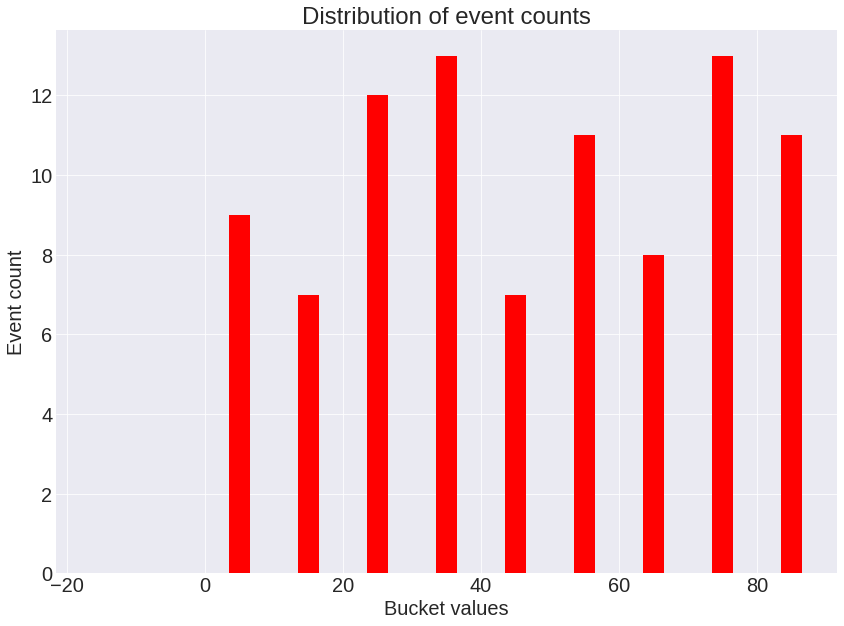

In [6]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["VALUE"]
y = hist_pandasDF["COUNT"]

# bar plot
ax.bar(x, y, width = 3.0, color='red')

ax.set_xlabel("Bucket values")
ax.set_ylabel("Event count")
ax.set_title("Distribution of event counts")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()

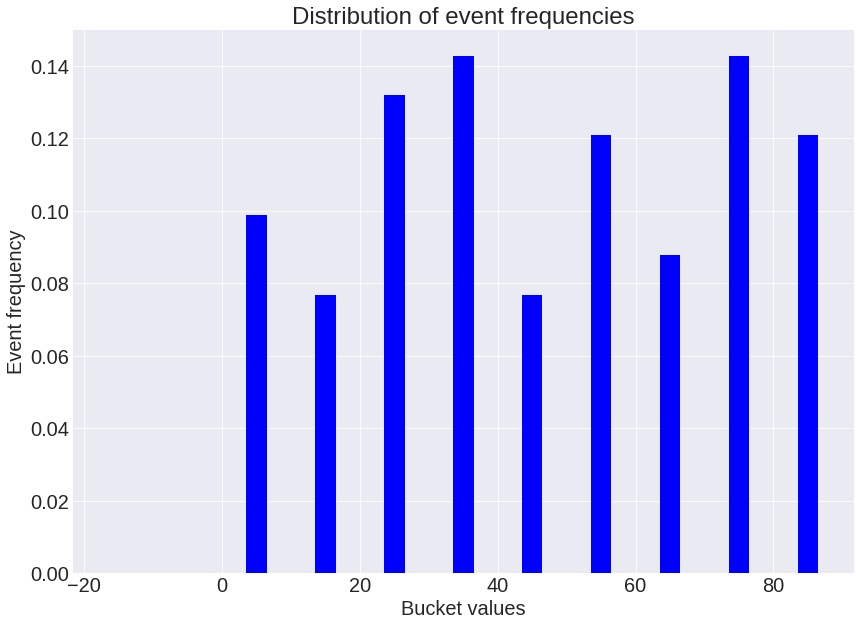

In [7]:


import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# histogram data
x = hist_pandasDF["VALUE"]
y = hist_pandasDF["FREQUENCY"]

# bar plot
ax.bar(x, y, width = 3.0, color='blue')

ax.set_xlabel("Bucket values")
ax.set_ylabel("Event frequency")
ax.set_title("Distribution of event frequencies")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.show()

